# Dynamic Properties of Lane Changing Vehicles

This notebook searches for relationships between (1) the velocity and position of a car entering a new lane and (2) the dynamic properties of other cars in its surroundings. This is important when considering a single lane with lane changes when the data on the other lanes is not available, as the new entering vehicle needs to be assigned a velocity and position that properly adheres to actual driving behaviors.

Original theory:
* The velocity of the lane changing vehicle is equal to the velocity of the leading vehicle in the new lane.
* The car enters halfway between the leading and lagginf cars in the new lane.

Hypothesis to be proven:
* The velocity of the car entering fall within the range of the velocity of the two new lane vehicles, and is normally distributed.
* The gap is normally distributed and centered at the midway point between the two new lane vehicles.
* The velocity/gap is a function of the velocity/gap of the new lane leading and lagging vehicle at the time of deciding to execute the lane change.

### Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pprint
import pandas as pd

## Import NGSIM Data

In [3]:
#### I 80 Data ####

# import headers from first file; the headers are the same in all files
with open('pm_4_velocity_filter_adjacent_lane_data.csv') as f:
    reader = csv.reader(f)
    header = next(reader)

# 4:00 - 4:15
data1 = np.genfromtxt('pm_4_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

# 5:00 - 5:15
data2 = np.genfromtxt('pm_5_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

# 5:15 - 5:30
data3 = np.genfromtxt('pm_515_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

In [75]:
#### US 101 Data ####

# 7:50 - 8:05
data4 = np.genfromtxt('pm_750_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

# 8:05 - 8:20
data5 = np.genfromtxt('pm_805_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

# 8:20 - 8:35
data6 = np.genfromtxt('pm_820_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

In [79]:
#### Other (dunno) ####

data7 = np.genfromtxt('pm_230_velocity_filter_adjacent_lane_data.csv', delimiter=',',skip_header=1)

## Collecting DLC Data

Data was previously filtered to provide accurate velocity data for each vehicle in the data. The data collected for each instance of a DLC is as follows:
* car_ID: id of the vehicle that executed the lane change
* v$_\alpha$(t): velocity of the lane changing car after entering the new lane
* v$_{\alpha -1}^l$(t): velocity of leading car in old lane after lane change
* v$_{\alpha -1}^{l'}$(t): velocity of leading car in new lane after lane change
* v$_{\alpha +1}^{l'}$(t): velocity of lagging car in new lane after lane change
* h$_{\alpha}^{l}$(t): lead headway in context of the old lane
* h$_{\alpha}^{l'}$(t): lead headway in context of the new lane
* h$_{\alpha-1}^{l'}$(t): lag headway in context of the new lane

In [109]:
def collect_DLC_data(data, DLC_data):
    """Appends previous discretionary lane change (DLC) data with new data from the provided dataset
    
    :data:
    :DLC_data:
    :lane_num_cur:
    :lane_num_target:
    
    :returns: new_DLC_data:
    """
    
    ## initialize output with old data
    new_DLC_data = DLC_data
    
    indx_DLC = np.where(data[:,-1]==1)[0]
    
    for i in indx_DLC:
        ############ collect data of interest ############
        
        # index of lead vehicle in adjacent lane before lane change
        vehID_lead_new_lane = int(data[i,-5])
        indx_lead_new_lane = np.where(np.logical_and(data[:,0]==vehID_lead_new_lane,data[:,1]==data[i,1]))[0]
        # index of lag vehicle in adjacent lane before lane change
        vehID_lag_new_lane = int(data[i,-4])
        indx_lag_new_lane = np.where(np.logical_and(data[:,0]==vehID_lag_new_lane,data[:,1]==data[i,1]))[0]
        # indx of lead car at after lane change
        indx_ProcedeID = np.where(np.logical_and(data[:,0]==data[i,7],data[:,1]==data[i+1,1]))[0]
        # indx of lead car at same time
        indx_followID = np.where(np.logical_and(data[:,0]==data[i,8],data[:,1]==data[i+1,1]))[0]
        
        if len(indx_lead_new_lane)!=0 and len(indx_lag_new_lane)!=0 and len(indx_ProcedeID)!=0 and len(indx_followID)!=0:
            indx_lead_new_lane = indx_lead_new_lane[0]
            indx_lag_new_lane = indx_lag_new_lane[0]
            indx_ProcedeID = indx_ProcedeID[0]
            indx_followID = indx_followID[0]

            veh_id = data[i,0]
            previous_lane = data[i,6]
            target_lane = data[i+1,6]

            v_filtered = data[i,-6]
            v_filtered_plus = data[i+1,-6]
            v_filtered_lead_new_lane = data[indx_lead_new_lane,-6]
            v_filtered_lead_new_lane_plus = data[indx_ProcedeID,-6]
            v_filtered_lag_new_lane = data[indx_lag_new_lane,-6]
            v_filtered_lag_new_lane_plus = data[indx_followID,-6]

            s_lead_new_lane = data[i,-3]
            s_lead_new_lane_plus = data[indx_ProcedeID,3] - data[i+1,3]
            s_lag_new_lane = data[i,-2]
            s_lag_new_lane_plus = data[i+1,3] - data[indx_followID,3]


            ############## append data to dict ###############

            new_DLC_data['veh_id'].append(veh_id)
            new_DLC_data['previous_lane'].append(previous_lane)
            new_DLC_data['target_lane'].append(target_lane)
            # filtered velocity data
            new_DLC_data['v_filtered'].append(v_filtered)
            new_DLC_data['v_filtered_plus'].append(v_filtered_plus)
            new_DLC_data['v_filtered_lead_new_lane'].append(v_filtered_lead_new_lane)
            new_DLC_data['v_filtered_lead_new_lane_plus'].append(v_filtered_lead_new_lane_plus)
            new_DLC_data['v_filtered_lag_new_lane'].append(v_filtered_lag_new_lane)
            new_DLC_data['v_filtered_lag_new_lane_plus'].append(v_filtered_lag_new_lane_plus)
            # space headway data
            new_DLC_data['s_lead_new_lane'].append(s_lead_new_lane)
            new_DLC_data['s_lead_new_lane_plus'].append(s_lead_new_lane_plus)
            new_DLC_data['s_lag_new_lane'].append(s_lag_new_lane)
            new_DLC_data['s_lag_new_lane_plus'].append(s_lag_new_lane_plus)
                               
    return new_DLC_data

## DLC I80 Data

In [110]:
# initialize dict variable for data collection
DLC_I80 = {'veh_id':                        [],  # id of vehicle that performed lane change
           'previous_lane':                 [],  # previous lane
           'target_lane':                   [],  # target lane
           'v_filtered':                    [],  # filtered velocity of vehicle performing lane change
           'v_filtered_plus':               [],  # filtered velocity of vehicle performing lane change
           'v_filtered_lead_new_lane':      [],  # filtered velocity of lead vehicle in new lane
           'v_filtered_lead_new_lane_plus': [],  # filtered velocity of lead vehicle in new lane
           'v_filtered_lag_new_lane':       [],  # filtered velocity of lag vehicle in new lane
           'v_filtered_lag_new_lane_plus':  [],  # filtered velocity of lag vehicle in new lane
           's_lead_new_lane':               [],  # gap between lead and lane change car in new lane
           's_lead_new_lane_plus':          [],  # gap between lead and lane change car in new lane
           's_lag_new_lane':                [],  # gap between lag and lane change car in new lane
           's_lag_new_lane_plus':           [],  # gap between lag and lane change car in new lane
          }

In [111]:
# collect and store DLC data
DLC_I80 = collect_DLC_data(data1, DLC_I80)
DLC_I80 = collect_DLC_data(data2, DLC_I80)
DLC_I80 = collect_DLC_data(data3, DLC_I80)

# dump collect I80 DLC data
np.save('DLC_I80_Data.npy', DLC_I80)

In [112]:
# present data as pandas dataframe
pd.DataFrame(DLC_I80)

,previous_lane,s_lag_new_lane,s_lag_new_lane_plus,s_lead_new_lane,s_lead_new_lane_plus,target_lane,v,v_filtered,v_filtered_lag_new_lane,v_filtered_lag_new_lane_plus,v_filtered_lead_new_lane,v_filtered_lead_new_lane_plus,v_filtered_plus,v_lag_new_lane,v_lag_new_lane_plus,v_lead_new_lane,v_lead_new_lane_plus,v_plus,veh_id
0,3.0,23.110,36.446,27.867,59.508,2.0,7.665720,7.047791,7.904278,8.115260,9.251369,7.602920,7.138089,8.103108,7.484364,9.142476,9.144000,7.626096,142.0
1,2.0,88.200,100.925,32.247,44.529,1.0,12.650724,12.024970,13.658726,8.842365,13.836923,10.036404,12.143720,13.720572,8.950452,13.714476,13.714476,12.923520,156.0
2,3.0,27.441,45.201,34.445,122.702,2.0,4.433316,4.659419,4.931939,4.736629,6.531157,5.433836,4.703228,4.725924,4.899660,6.477000,6.969252,4.661916,194.0
3,2.0,143.313,56.426,33.785,56.979,1.0,7.930896,8.038592,13.145611,5.358455,13.229389,6.671046,8.078864,13.862304,5.434584,13.130784,13.025628,7.964424,194.0
4,3.0,35.839,177.380,44.813,66.924,2.0,7.470648,7.561641,6.627436,5.466443,6.884920,6.549137,7.545195,6.126480,5.484876,7.010400,7.025640,7.469124,240.0
5,3.0,73.364,45.887,49.307,38.182,2.0,7.100316,7.057518,3.195549,7.617543,6.611227,6.646448,7.058594,2.810256,7.409688,6.173724,6.635496,7.168896,299.0
6,3.0,39.224,57.970,44.426,58.153,2.0,9.534144,9.511106,8.039910,9.144369,10.651218,10.800639,9.574788,8.098536,9.144000,11.548872,11.746992,9.473184,394.0
7,3.0,54.178,73.688,61.020,58.868,2.0,7.697724,7.987397,6.889940,8.502040,8.186031,7.838730,7.973924,7.447788,7.601712,7.778496,8.071104,7.799832,397.0
8,2.0,136.125,62.504,83.164,51.192,1.0,11.789664,11.676750,20.808815,9.421901,19.762843,9.008423,11.701634,21.087588,9.585960,21.870924,22.055328,11.788140,447.0
9,3.0,74.883,44.867,20.165,50.389,2.0,7.620000,7.616639,9.272406,7.699940,9.016525,7.790918,7.624311,9.144000,7.620000,8.700516,8.891016,7.610856,581.0


## DLC US 101 Data

In [113]:
# initialize dict variable for data collection
DLC_US101 = {'veh_id':                        [],  # id of vehicle that performed lane change
             'previous_lane':                 [],  # previous lane
             'target_lane':                   [],  # target lane
             'v_filtered':                    [],  # filtered velocity of vehicle performing lane change
             'v_filtered_plus':               [],  # filtered velocity of vehicle performing lane change
             'v_filtered_lead_new_lane':      [],  # filtered velocity of lead vehicle in new lane
             'v_filtered_lead_new_lane_plus': [],  # filtered velocity of lead vehicle in new lane
             'v_filtered_lag_new_lane':       [],  # filtered velocity of lag vehicle in new lane
             'v_filtered_lag_new_lane_plus':  [],  # filtered velocity of lag vehicle in new lane
             's_lead_new_lane':               [],  # gap between lead and lane change car in new lane
             's_lead_new_lane_plus':          [],  # gap between lead and lane change car in new lane
             's_lag_new_lane':                [],  # gap between lag and lane change car in new lane
             's_lag_new_lane_plus':           [],  # gap between lag and lane change car in new lane
            }

In [114]:
# collect and store DLC data
DLC_US101 = collect_DLC_data(data4, DLC_US101)
DLC_US101 = collect_DLC_data(data5, DLC_US101)
DLC_US101 = collect_DLC_data(data6, DLC_US101)

# dump collect I80 DLC data
np.save('DLC_US101_Data.npy', DLC_US101)

In [115]:
# present data as pandas dataframe
pd.DataFrame(DLC_US101)

,previous_lane,s_lag_new_lane,s_lag_new_lane_plus,s_lead_new_lane,s_lead_new_lane_plus,target_lane,v,v_filtered,v_filtered_lag_new_lane,v_filtered_lag_new_lane_plus,v_filtered_lead_new_lane,v_filtered_lead_new_lane_plus,v_filtered_plus,v_lag_new_lane,v_lag_new_lane_plus,v_lead_new_lane,v_lead_new_lane_plus,v_plus,veh_id
0,3.0,58.733,94.394,146.333,29.014,2.0,14.125956,14.252307,9.613371,11.132334,12.699876,11.380073,14.345089,9.144000,11.177016,12.664440,12.911328,14.499336,37.0
1,3.0,74.889,100.565,85.496,64.641,2.0,17.558004,17.121815,13.342412,15.191329,16.949132,13.997751,17.163232,13.069824,15.238476,16.773144,16.786860,17.913096,49.0
2,2.0,65.958,107.826,60.471,98.823,1.0,15.227808,15.069453,16.216973,12.292053,18.254346,16.820436,15.071508,16.658844,12.192000,18.269712,18.245328,15.157704,56.0
3,3.0,73.700,76.544,178.577,79.284,2.0,17.468088,17.264955,13.456943,18.331250,14.809983,17.153427,17.246881,13.630656,18.112740,14.805660,14.633448,17.536668,64.0
4,2.0,52.328,67.301,45.195,51.312,1.0,14.211300,14.290844,16.011371,14.616674,16.699812,13.221820,14.259685,15.467076,15.240000,16.899636,16.562832,13.886688,69.0
5,3.0,83.299,143.351,105.993,80.223,2.0,18.120360,18.335070,13.792368,18.019175,17.361462,16.914237,18.356080,13.709904,18.010632,17.532096,17.682972,18.455640,76.0
6,3.0,41.153,142.908,48.089,103.673,2.0,17.052036,17.921454,15.733885,17.696572,16.482695,19.330200,17.919104,15.765780,17.945100,16.760952,16.517112,17.538192,97.0
7,2.0,116.098,68.424,40.340,34.991,1.0,17.650968,17.114385,15.336972,15.963487,16.939942,16.233901,17.125946,15.238476,16.407384,16.867632,16.948404,17.646396,115.0
8,3.0,65.195,61.872,32.489,72.572,2.0,13.123164,12.739037,14.413998,13.431143,14.067983,14.737456,12.736678,13.947648,13.214604,13.691616,13.773912,12.815316,141.0
9,2.0,111.863,56.799,102.268,61.020,1.0,14.548104,14.391313,12.746438,15.173969,16.860617,13.861907,14.409401,11.939016,15.139416,17.137380,17.516856,14.567916,200.0


## DLC Other Data

In [116]:
# initialize dict variable for data collection
DLC_other = {'veh_id':                        [],  # id of vehicle that performed lane change
             'previous_lane':                 [],  # previous lane
             'target_lane':                   [],  # target lane
             'v':                             [],  # velocity of vehicle performing lane change
             'v_plus':                        [],  # velocity of vehicle performing lane change
             'v_lead_new_lane':               [],  # velocity of lead vehicle in new lane
             'v_lead_new_lane_plus':          [],  # velocity of lead vehicle in new lane
             'v_lag_new_lane':                [],  # velocity of lag vehicle in new lane
             'v_lag_new_lane_plus':           [],  # velocity of lag vehicle in new lane
             'v_filtered':                    [],  # filtered velocity of vehicle performing lane change
             'v_filtered_plus':               [],  # filtered velocity of vehicle performing lane change
             'v_filtered_lead_new_lane':      [],  # filtered velocity of lead vehicle in new lane
             'v_filtered_lead_new_lane_plus': [],  # filtered velocity of lead vehicle in new lane
             'v_filtered_lag_new_lane':       [],  # filtered velocity of lag vehicle in new lane
             'v_filtered_lag_new_lane_plus':  [],  # filtered velocity of lag vehicle in new lane
             's_lead_new_lane':               [],  # gap between lead and lane change car in new lane
             's_lead_new_lane_plus':          [],  # gap between lead and lane change car in new lane
             's_lag_new_lane':                [],  # gap between lag and lane change car in new lane
             's_lag_new_lane_plus':           [],  # gap between lag and lane change car in new lane
            }

In [117]:
# collect and store DLC data
DLC_other = collect_DLC_data(data7, DLC_other)

# dump collect I80 DLC data
np.save('DLC_Other_Data.npy', DLC_other)

In [118]:
# present data as pandas dataframe
pd.DataFrame(DLC_other)

,previous_lane,s_lag_new_lane,s_lag_new_lane_plus,s_lead_new_lane,s_lead_new_lane_plus,target_lane,v,v_filtered,v_filtered_lag_new_lane,v_filtered_lag_new_lane_plus,v_filtered_lead_new_lane,v_filtered_lead_new_lane_plus,v_filtered_plus,v_lag_new_lane,v_lag_new_lane_plus,v_lead_new_lane,v_lead_new_lane_plus,v_plus,veh_id
0,2.0,76.44,288.84,411.00,118.26,1.0,28.34640,28.221507,29.779315,27.715501,36.630964,25.391394,28.223299,30.97530,26.99766,37.58184,37.53612,28.27782,14374.0
1,3.0,261.67,311.33,75.35,39.83,2.0,31.20390,29.283829,31.320105,31.502074,26.316668,27.710733,29.098128,30.99816,32.07258,25.62606,25.16886,30.26664,38.0
2,3.0,45.50,144.10,105.10,71.00,2.0,26.06040,26.947909,26.377886,24.066234,25.547927,24.404721,26.961261,26.06040,23.77440,25.60320,25.37460,26.97480,18.0
3,3.0,68.85,244.94,185.24,113.89,2.0,34.70148,33.659194,27.132868,30.571626,27.845192,27.762527,33.703013,28.46070,30.10662,27.43200,27.66060,34.63290,15.0
4,2.0,99.10,160.00,52.40,55.40,1.0,27.20340,26.918735,27.509481,22.389486,32.022086,26.455650,27.103436,27.43200,22.40280,36.34740,34.29000,27.66060,15.0
5,3.0,84.50,180.10,190.00,102.80,2.0,29.26080,29.120412,25.633394,29.452428,25.998724,25.940381,29.073443,25.83180,28.80360,25.37460,25.83180,28.34640,107.0
6,3.0,45.32,165.27,108.22,43.02,2.0,34.86150,33.435075,29.156530,22.065849,28.355086,32.385212,33.518688,29.87802,21.25980,29.71800,29.26080,34.54146,8.0
7,2.0,44.00,82.80,173.50,38.20,1.0,30.86100,30.993212,26.538662,27.578074,28.879431,25.551687,30.964060,26.74620,27.43200,28.80360,30.17520,30.86100,8.0
8,3.0,507.30,130.70,125.80,34.70,2.0,26.06040,26.772107,30.973066,23.490150,25.387555,25.785743,26.839884,30.86100,23.54580,25.83180,25.37460,26.74620,1.0
9,2.0,66.40,8.66,246.31,108.02,1.0,21.46554,22.977963,24.574474,24.401249,30.854999,29.582927,23.108984,24.27732,23.77440,31.47822,31.75254,21.48840,3945.0


## Data Processing

With the above data points collected, a systematic approach to analyzing the data must be developed. We begin by taking into consideration the distribution of the following two terms:

* v$_{rel}=\frac{v_{\alpha -1}^{l'}(t)-v_{\alpha}(t)}{v_{\alpha -1}^{l'}(t)-v_{\alpha +1}^{l'}(t)}$: The relative velocity of the entering vehicle wrt the leading and lagging vehicles in the new lane
* x$_{rel}=\frac{h_{\alpha-1}^{l'}(t)}{h_{\alpha-1}^{l'}(t)+h_\alpha^{l'}(t)}$: The relative position in the gap that the entering vehicle chooses to occupy

(conclusions)

In [98]:
data1[1000,8]

17.0

In [84]:
header

['vehID',
 'fID',
 'locX',
 'locY',
 'globalX',
 'globalY',
 'laneID',
 'PrecedeID',
 'followID',
 'spaceHeadway',
 'timeHeadway',
 'width',
 'vel',
 'filterVeloc',
 'adj_lane_lead_vehID',
 'adj_lane_lag_vehID',
 'adj_lane_lead_spaceHeadway',
 'adj_lane_lag_spaceHeadway',
 'DLC']

In [130]:
v_c = np.append(np.append(np.array(DLC_I80['v_filtered_plus']),np.array(DLC_US101['v_filtered_plus'])),
                np.array(DLC_other['v_filtered_plus']))

v_lead = np.append(np.append(np.array(DLC_I80['v_filtered_lead_new_lane_plus']),
                             np.array(DLC_US101['v_filtered_lead_new_lane_plus'])),
                   np.array(DLC_other['v_filtered_lead_new_lane_plus']))

v_lag = np.append(np.append(np.array(DLC_I80['v_filtered_lag_new_lane_plus']),
                            np.array(DLC_US101['v_filtered_lag_new_lane_plus'])),
                  np.array(DLC_other['v_filtered_lag_new_lane_plus']))

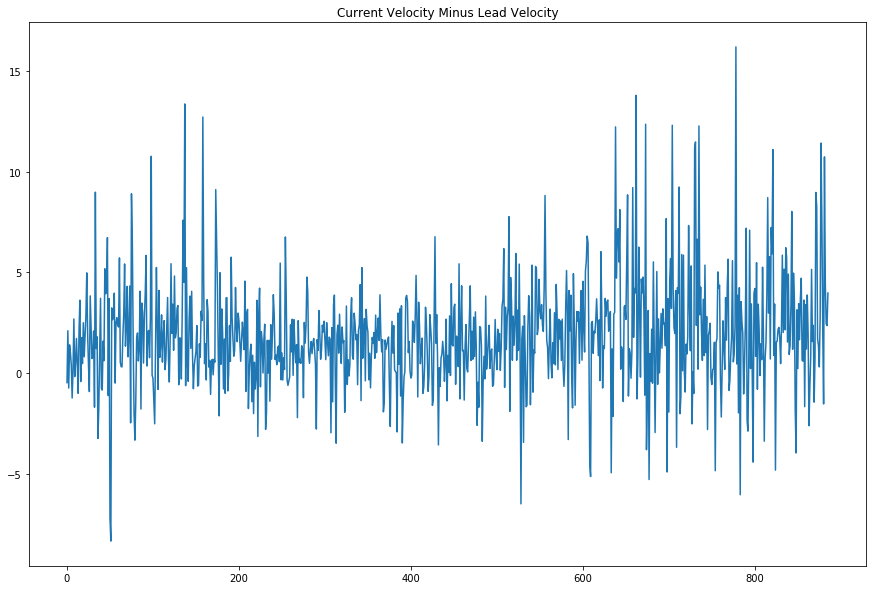

In [139]:
plt.figure(figsize=(15,10))

plt.plot(v_c-v_lead)
plt.title('Current Velocity Minus Lead Velocity')

plt.show()

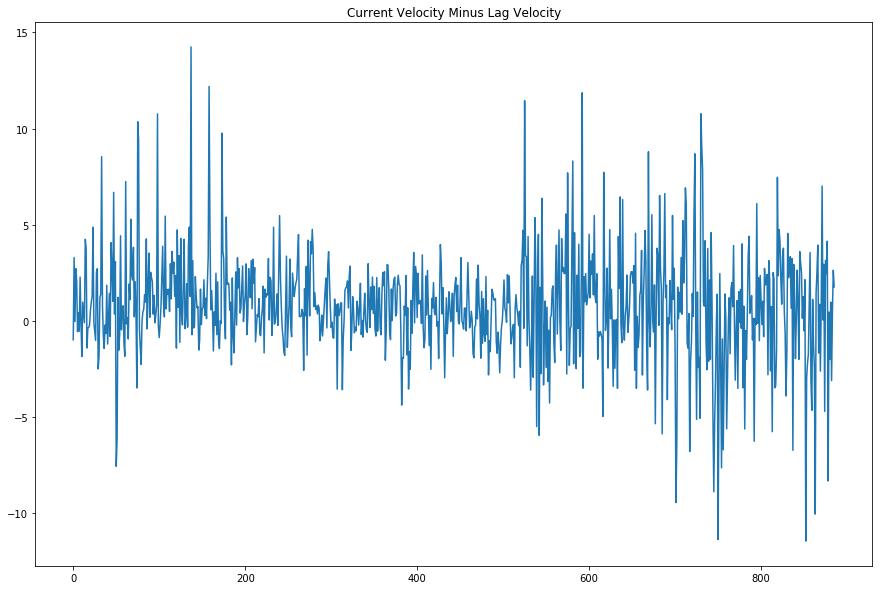

In [137]:
plt.figure(figsize=(15,10))

plt.plot(v_c-v_lag)
plt.title('Current Velocity Minus Lag Velocity')

plt.show()

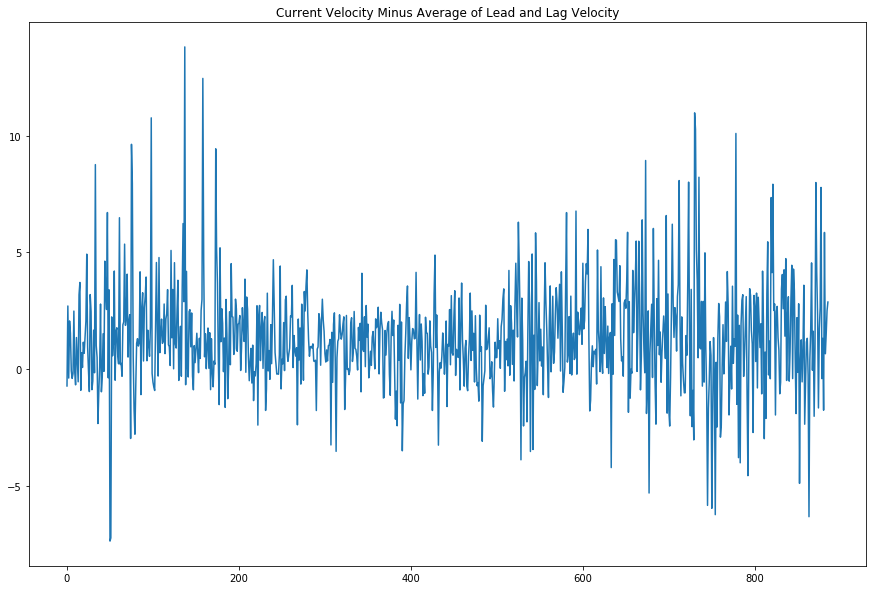

In [138]:
plt.figure(figsize=(15,10))

plt.plot(v_c-(v_lead+v_lag)/2)
plt.title('Current Velocity Minus Average of Lead and Lag Velocity')

plt.show()

In [163]:
data = v_c - v_lead
bins = np.arange(-10, 11)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [170]:
binned_data, bins = np.histogram(data,bins)

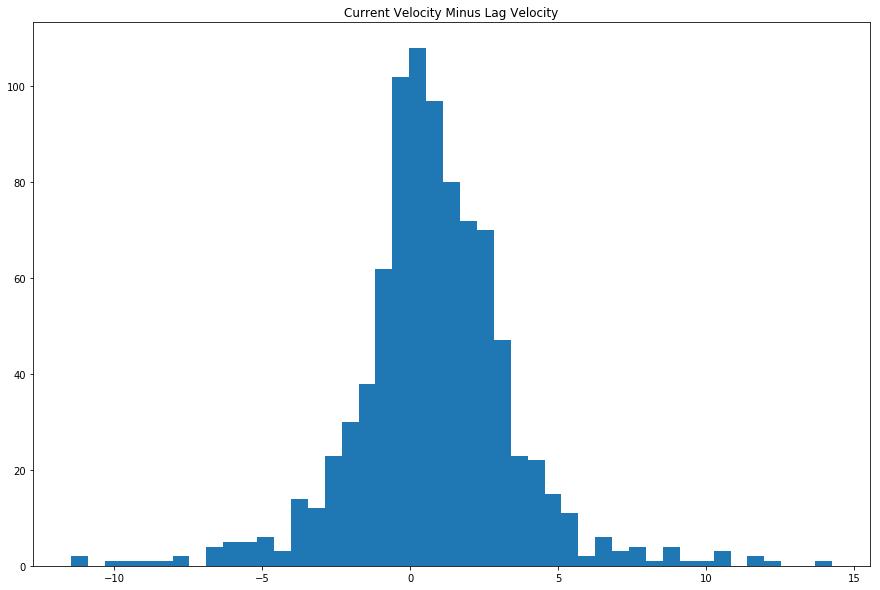

In [191]:
plt.figure(figsize=(15,10))

n, bins_vrel, patches = plt.hist(v_c-v_lag, bins='auto')
plt.title('Current Velocity Minus Lag Velocity')

plt.show()

In [183]:
s_lag = np.append(np.append(np.array(DLC_I80['s_lag_new_lane_plus']),
                            np.array(DLC_US101['s_lag_new_lane_plus'])),
                  np.array(DLC_other['s_lag_new_lane_plus']))

s_lead = np.append(np.append(np.array(DLC_I80['s_lead_new_lane_plus']),
                             np.array(DLC_US101['s_lead_new_lane_plus'])),
                   np.array(DLC_other['s_lead_new_lane_plus']))

gap = s_lead+s_lag

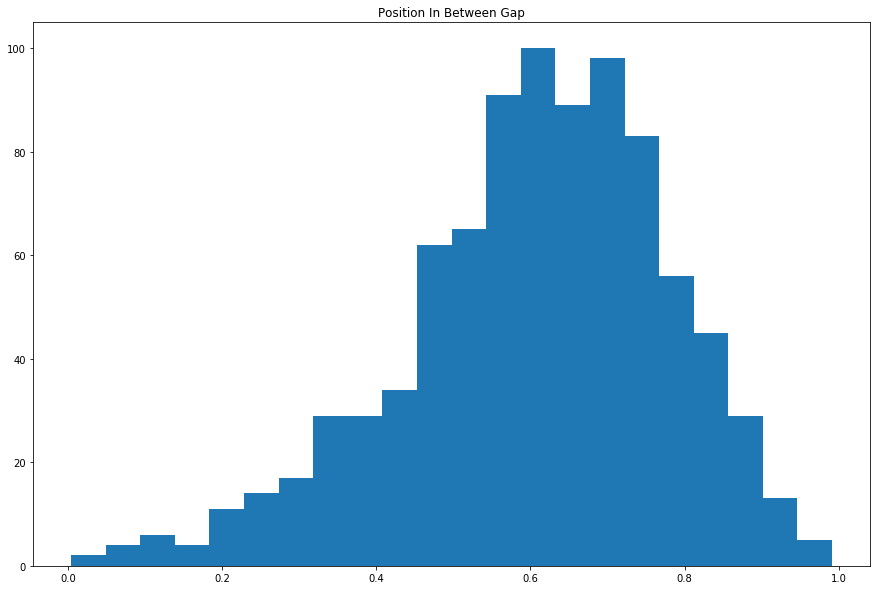

In [193]:
plt.figure(figsize=(15,10))

n, bins_srel, patches = plt.hist(np.divide(s_lag,gap), bins='auto')
plt.title('Position In Between Gap')

plt.show()

In [192]:
bins_vrel

array([-11.44478408, -10.87378487, -10.30278566,  -9.73178646,
        -9.16078725,  -8.58978804,  -8.01878883,  -7.44778962,
        -6.87679041,  -6.3057912 ,  -5.73479199,  -5.16379278,
        -4.59279358,  -4.02179437,  -3.45079516,  -2.87979595,
        -2.30879674,  -1.73779753,  -1.16679832,  -0.59579911,
        -0.0247999 ,   0.5461993 ,   1.11719851,   1.68819772,
         2.25919693,   2.83019614,   3.40119535,   3.97219456,
         4.54319377,   5.11419298,   5.68519218,   6.25619139,
         6.8271906 ,   7.39818981,   7.96918902,   8.54018823,
         9.11118744,   9.68218665,  10.25318586,  10.82418506,
        11.39518427,  11.96618348,  12.53718269,  13.1081819 ,
        13.67918111,  14.25018032])